# Imports

In [1]:
import pandas as pd
import numpy as np
import glob
import re
import string
from bs4 import BeautifulSoup

# sklearn
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# nltk
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 

# visualization 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [56]:
df = pd.read_csv('datasets\processed_reshaped_data.csv')

In [13]:
df.shape

(642, 2)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df['Description'], df['JobTitle'], test_size=0.3,
                                                    random_state=42, stratify=df['JobTitle'])

## RandomForestClassifier

In [5]:
rf = RandomForestClassifier()

pipline = Pipeline(steps=[
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', rf)
])

In [6]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 15, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

On each iteration, the algorithm will choose a difference combination of the features. Altogether, there are 5 * 2 * 6 * 3 * 3 * 2 = 1080 settings! However, the benefit of a random search is that we are not trying every combination, but selecting at random to sample a wide range of values.

In [7]:
# hyperparameter tuning
def grid_search():
    param_grid = {
        'model__n_estimators': n_estimators,
        'model__max_features': max_features,
        'model__max_depth': max_depth,
        'model__min_samples_split': min_samples_split,
        'model__min_samples_leaf': min_samples_leaf,
        'model__bootstrap': bootstrap
    }

    search = RandomizedSearchCV(pipline, param_grid, cv=5, n_jobs=-1)
    search.fit(X_train,y_train)

    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)

In [8]:
import time

start = time.time()

grid_search()

end = time.time()
print('execution time in minutes: ', (end - start)/60) 

Best parameter (CV score=0.920):
{'model__n_estimators': 800, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': None, 'model__bootstrap': False}
execution time in minutes:  0.9659295996030172


In [9]:
# adding best hyperparameter

rf = RandomForestClassifier(min_samples_split = 10, max_depth=None, n_estimators = 800, min_samples_leaf = 2,
                            max_features = 'auto',bootstrap = True)

pipline = Pipeline(steps=[
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', rf)
])

In [10]:
pipline.fit(X_train,y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('model',
                 RandomForestClassifier(min_samples_leaf=2,
                                        min_samples_split=10,
                                        n_estimators=800))])

In [11]:
predictions = pipline.predict(X_test)

## Code to find out if we need more data

In [218]:
df_report = pd.DataFrame(classification_report(y_test, predictions, output_dict=True)).transpose()

C:\Users\User\anaconda3\envs\ML Technion\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\envs\ML Technion\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\envs\ML Technion\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [259]:
df_report = df_report[:-3]

<AxesSubplot:>

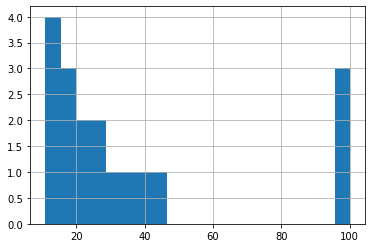

In [220]:
df.JobTitle.value_counts().hist(bins=20)

In [221]:
df1 = df.JobTitle.value_counts().to_frame().sort_index()
df1.rename({'JobTitle':'Count'}, inplace=True,axis='columns')

In [228]:
df_report = pd.concat([df_report, df1], axis=1)

In [231]:
under_20 =  df_report[df_report.Count<=20]
under_2

,precision,recall,f1-score,support,Count
Assistant Director of Nursing,1.0,0.333333,0.500000,3.0,11
Data Science Director,1.0,0.333333,0.500000,6.0,19
Maintenance Planner,1.0,0.800000,0.888889,5.0,16
Neuropsychologist,0.0,0.000000,0.000000,3.0,11
Process Associate,1.0,1.000000,1.000000,4.0,14
Small Animal Veterinarian,1.0,0.750000,0.857143,4.0,12
Tax Analyst,1.0,0.200000,0.333333,5.0,16


In [233]:
over_20 = df_report[df_report.Count>20]
over_20

,precision,recall,f1-score,support,Count
Automotive Service Manager,1.000000,1.000000,1.000000,10.0,34
Content Strategist,0.916667,0.846154,0.880000,13.0,43
Growth Strategy Manager,1.000000,0.888889,0.941176,9.0,30
Human Resources Assistant,1.000000,1.000000,1.000000,7.0,24
Loan Officer,0.966667,0.966667,0.966667,30.0,100
Medical Laboratory Technician (MLT),1.000000,0.625000,0.769231,8.0,25
Neonatal Nurse,1.000000,1.000000,1.000000,8.0,26
Pediatric Anesthesiologist,1.000000,1.000000,1.000000,6.0,21
Physical Therapist Assistant (PTA),0.857143,1.000000,0.923077,30.0,100
Software Engineer,0.666667,1.000000,0.800000,30.0,100


In [258]:
summary = pd.DataFrame([[under_20.precision.mean(), under_20.recall.mean(),under_20['f1-score'].mean()],
                        [over_20.precision.mean(), over_20.recall.mean(),over_20['f1-score'].mean()]],
                       columns=df_report.columns[:3], index = ['under_20','over_20'])
print(summary)
print('\nBased on datadet: datasets\processed_reshaped_data.csv')
print('The amount of observations is in df: ', len(df))

          precision    recall  f1-score
under_20   0.857143  0.488095  0.582766
over_20    0.938528  0.931216  0.926983

Based on datadet: datasets\processed_reshaped_data.csv
The amount of observations is in df:  642


# Finding the formula of 'support' - just for fun

In [223]:
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
LR = LinearRegression(fit_intercept=True)

In [224]:
df2 = pd.concat([df_report, df1], axis=1)
#separate the other attributes from the predicting attribute
x = df2[['Count']]
#separte the predicting attribute into Y for model training 
y = df2['support']
LR.fit(x,y)
LR.coef_

array([0.2998372])

In [225]:
df2['pred_spport'] =  LR.predict(x)

In [226]:
score= r2_score(y,df2['pred_spport'])
print('r2 socre is',score)
print('mean_sqrd_error is==',mean_squared_error(y,df2['pred_spport']))
print('root_mean_squared error of is==',np.sqrt(mean_squared_error(y,df2['pred_spport'])))

r2 socre is 0.9993141494592955
mean_sqrd_error is== 0.056148720963535785
root_mean_squared error of is== 0.2369572133604204


In [227]:
df2

,precision,recall,f1-score,support,Count,pred_spport
Assistant Director of Nursing,1.000000,0.333333,0.500000,3.0,11,3.326238
Automotive Service Manager,1.000000,1.000000,1.000000,10.0,34,10.222494
Content Strategist,0.916667,0.846154,0.880000,13.0,43,12.921028
Data Science Director,1.000000,0.333333,0.500000,6.0,19,5.724936
Growth Strategy Manager,1.000000,0.888889,0.941176,9.0,30,9.023145
Human Resources Assistant,1.000000,1.000000,1.000000,7.0,24,7.224122
Loan Officer,0.966667,0.966667,0.966667,30.0,100,30.011749
Maintenance Planner,1.000000,0.800000,0.888889,5.0,16,4.825424
Medical Laboratory Technician (MLT),1.000000,0.625000,0.769231,8.0,25,7.523959
Neonatal Nurse,1.000000,1.000000,1.000000,8.0,26,7.823796
